In [1]:
from pathlib import Path
import numpy as np
from PIL import Image, ImageDraw
from matplotlib import pyplot as plt
import cv2
import os
from src.features.build_features import getLBPimage, create_lbp_by_rings
from src.models.train_model import multiple_cls_test, preprocess_data

__file__ = os.path.abspath('')

project_dir = Path(__file__).resolve()


In [2]:
ref_image_path = '../data/raw/220413/tiff/reflection'

/Users/bruceliu/projects/milk_cls/data/raw/220413/tiff/reflection/dark_blue/220413A_X0p7_RWhite.tiff


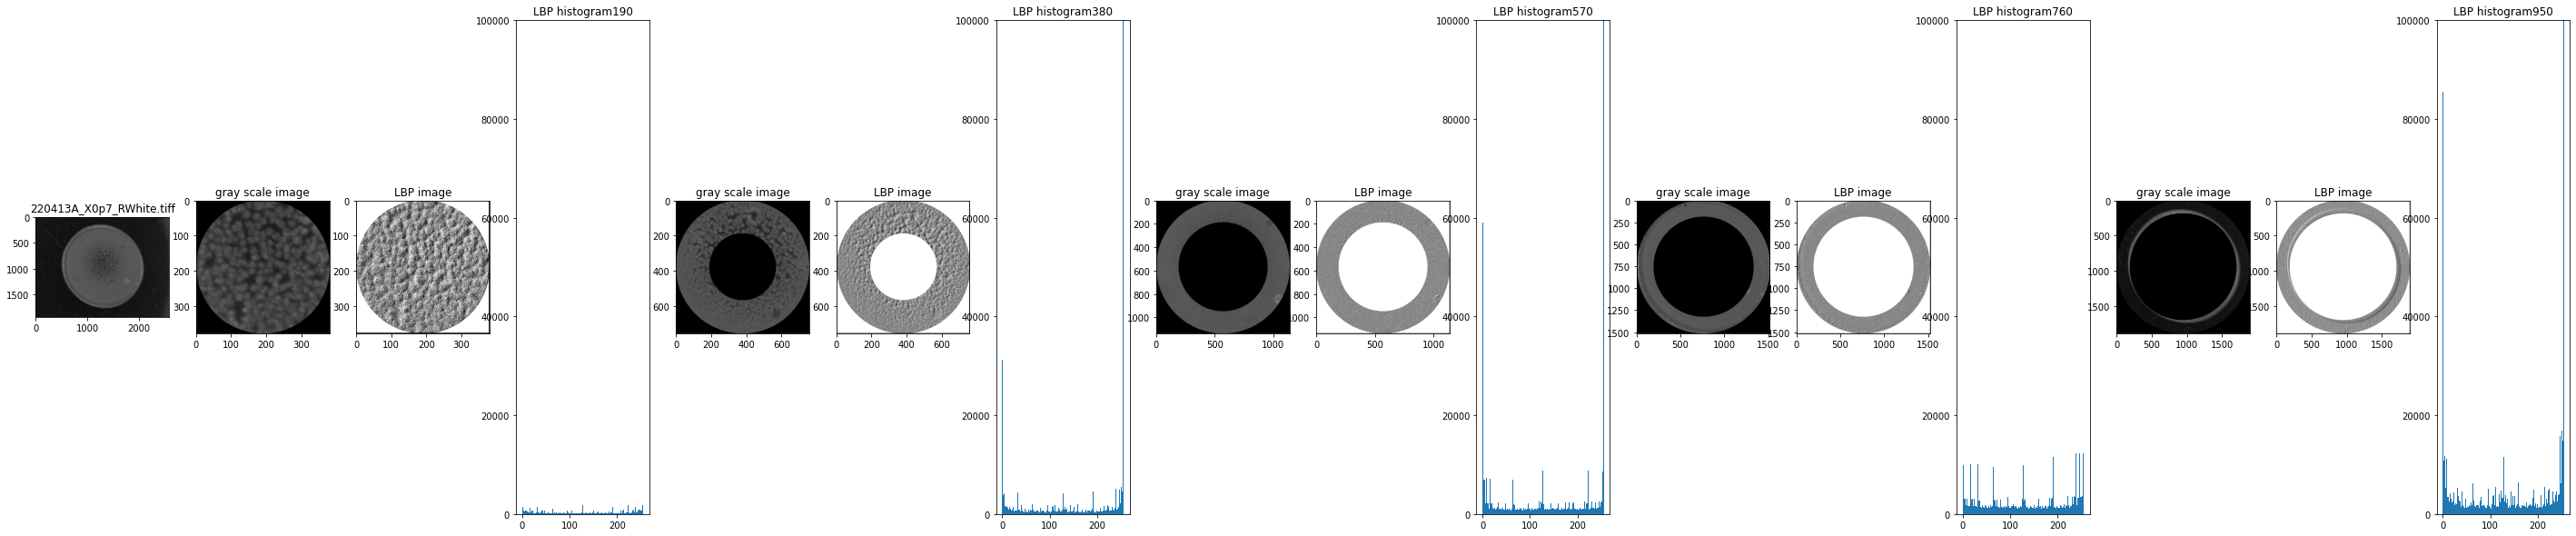

/Users/bruceliu/projects/milk_cls/data/raw/220413/tiff/reflection/dark_blue/220413B_X0p7_RWhite.tiff
/Users/bruceliu/projects/milk_cls/data/raw/220413/tiff/reflection/dark_blue/220413C_X0p7_RWhite.tiff
/Users/bruceliu/projects/milk_cls/data/raw/220413/tiff/reflection/dark_blue/220413D_X0p7_RWhite.tiff
/Users/bruceliu/projects/milk_cls/data/raw/220413/tiff/reflection/dark_blue/220413E_X0p7_RWhite.tiff
/Users/bruceliu/projects/milk_cls/data/raw/220413/tiff/reflection/dark_blue/220413F_X0p7_RWhite.tiff
/Users/bruceliu/projects/milk_cls/data/raw/220413/tiff/reflection/dark_blue/220413G_X0p7_RWhite.tiff
/Users/bruceliu/projects/milk_cls/data/raw/220413/tiff/reflection/dark_blue/220413H_X0p7_RWhite.tiff
/Users/bruceliu/projects/milk_cls/data/raw/220413/tiff/reflection/dark_blue/220413I_X0p7_RWhite.tiff
/Users/bruceliu/projects/milk_cls/data/raw/220413/tiff/reflection/dark_blue/220413J_X0p7_RWhite.tiff
/Users/bruceliu/projects/milk_cls/data/raw/220413/tiff/reflection/dark_blue/220413K_X0p7_RW

In [3]:
ref_dark_blue = Path(str(ref_image_path) + '/dark_blue').resolve()

ref_db_data, ref_db_labels = create_lbp_by_rings(ref_dark_blue)

In [4]:
def NormalizeData(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))

/Users/bruceliu/projects/milk_cls/data/raw/220413/tiff/reflection/dbm_gm/220413Y_X0p7_RWhite.tiff


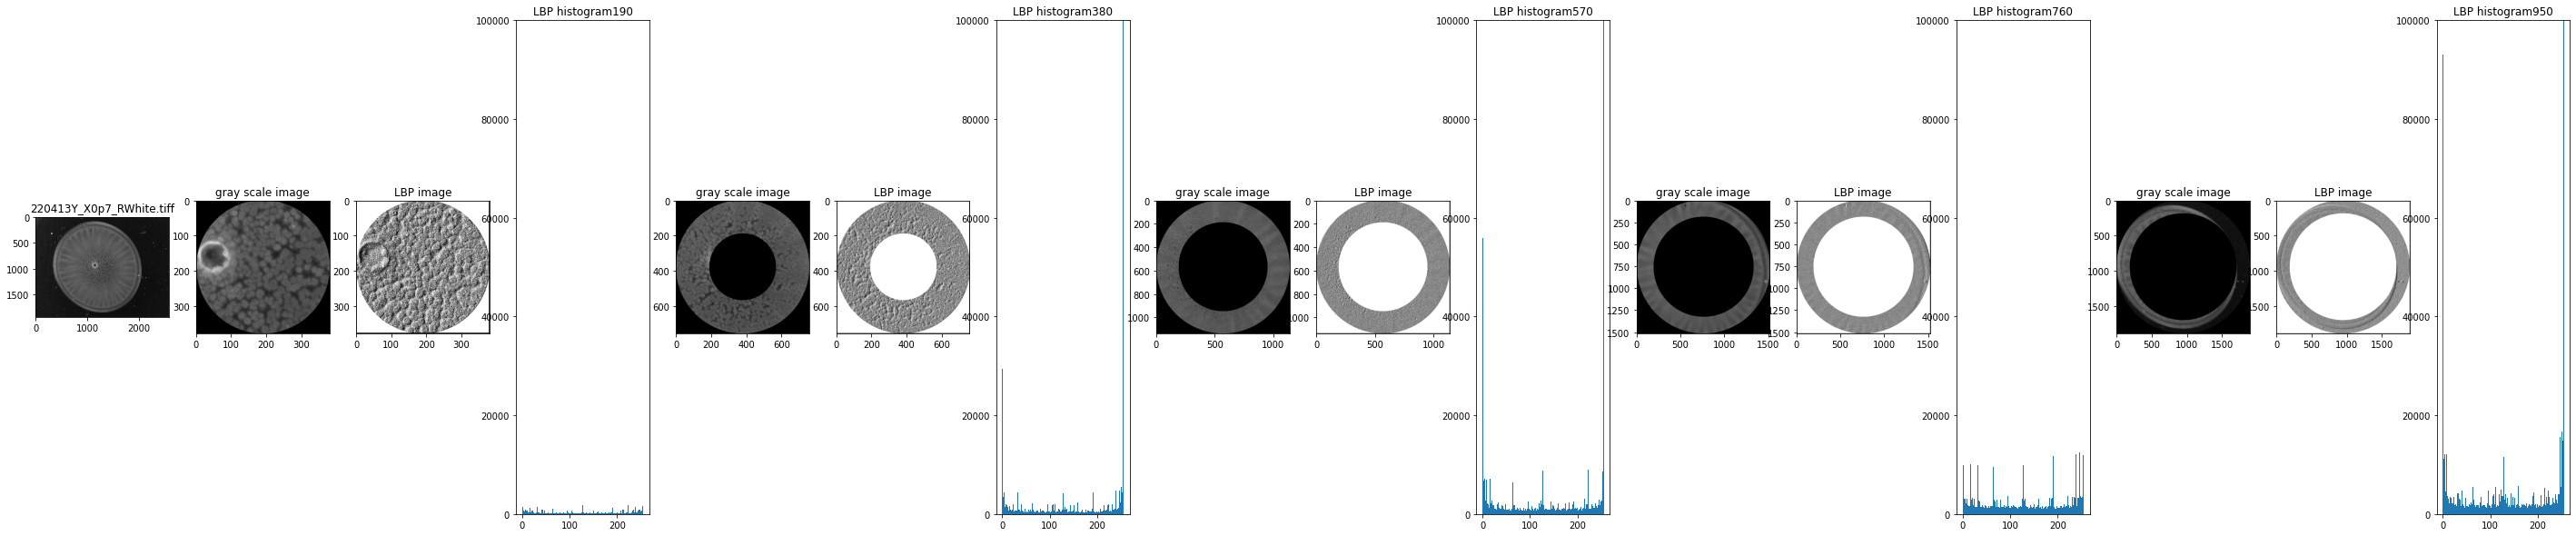

/Users/bruceliu/projects/milk_cls/data/raw/220413/tiff/reflection/dbm_gm/220413ZA_X0p7_RWhite.tiff
/Users/bruceliu/projects/milk_cls/data/raw/220413/tiff/reflection/dbm_gm/220413ZB_X0p7_RWhite.tiff
/Users/bruceliu/projects/milk_cls/data/raw/220413/tiff/reflection/dbm_gm/220413ZC_X0p7_RWhite.tiff
/Users/bruceliu/projects/milk_cls/data/raw/220413/tiff/reflection/dbm_gm/220413ZD_X0p7_RWhite.tiff
/Users/bruceliu/projects/milk_cls/data/raw/220413/tiff/reflection/dbm_gm/220413ZE_X0p7_RWhite.tiff
/Users/bruceliu/projects/milk_cls/data/raw/220413/tiff/reflection/dbm_gm/220413ZF_X0p7_RWhite.tiff
/Users/bruceliu/projects/milk_cls/data/raw/220413/tiff/reflection/dbm_gm/220413ZG_X0p7_RWhite.tiff
/Users/bruceliu/projects/milk_cls/data/raw/220413/tiff/reflection/dbm_gm/220413ZH_X0p7_RWhite.tiff
/Users/bruceliu/projects/milk_cls/data/raw/220413/tiff/reflection/dbm_gm/220413ZI_X0p7_RWhite.tiff
/Users/bruceliu/projects/milk_cls/data/raw/220413/tiff/reflection/dbm_gm/220413ZJ_X0p7_RWhite.tiff
/Users/bru

In [5]:
ref_dbm_path = Path(str(ref_image_path) + '/dbm_gm').resolve()

ref_dbm_data, ref_dbm_labels = create_lbp_by_rings(ref_dbm_path)

/Users/bruceliu/projects/milk_cls/data/raw/220413/tiff/reflection/green_trim/220413M_X0p7_RWhite.tiff


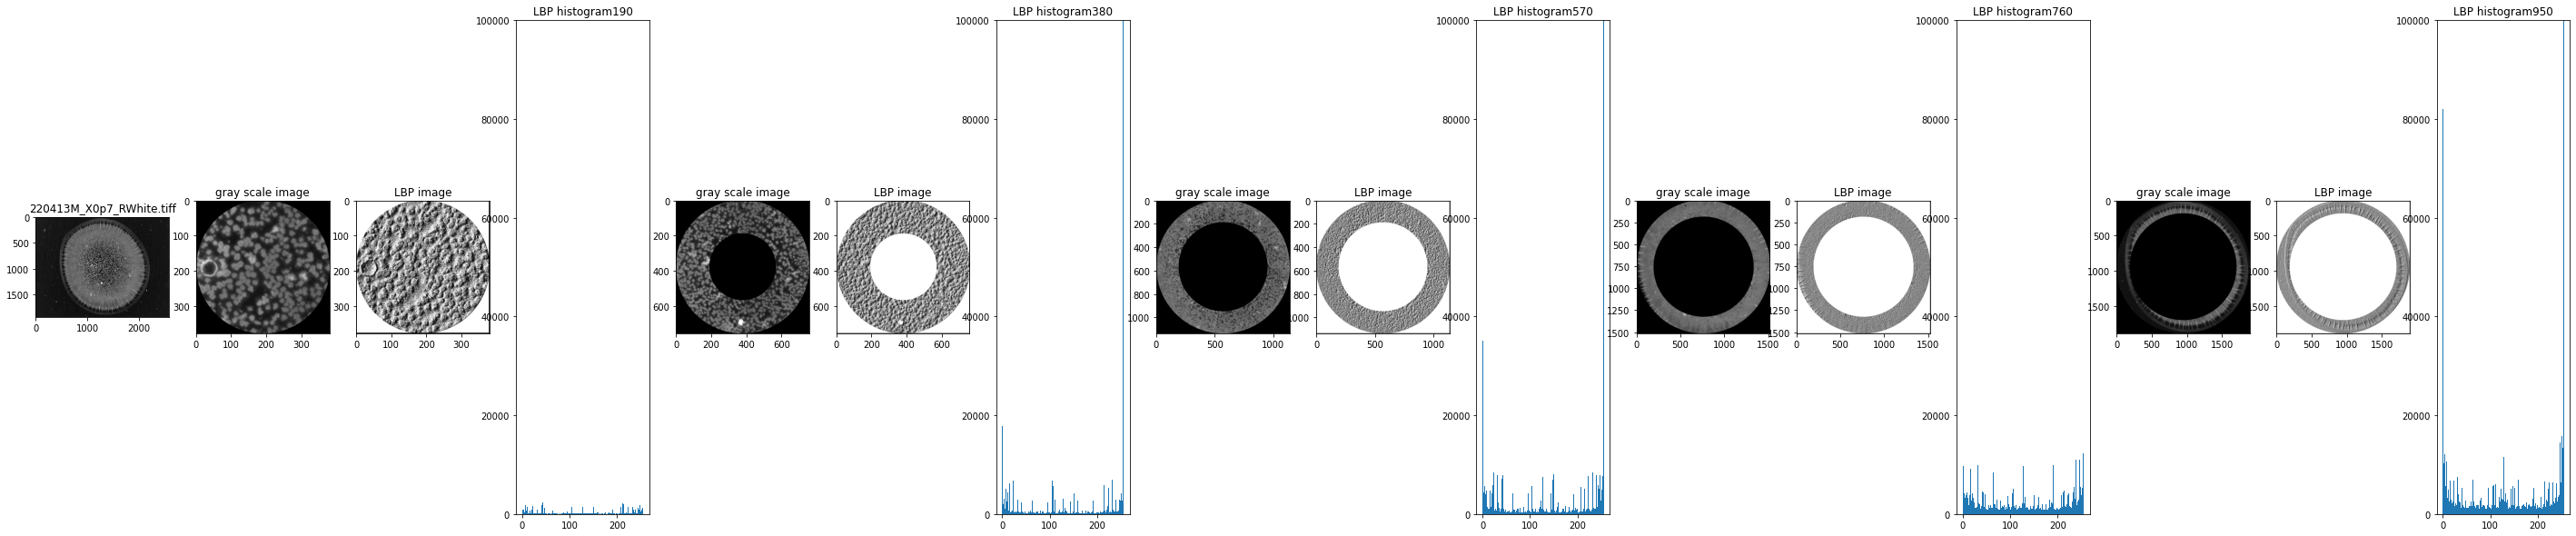

/Users/bruceliu/projects/milk_cls/data/raw/220413/tiff/reflection/green_trim/220413N_X0p7_RWhite.tiff
/Users/bruceliu/projects/milk_cls/data/raw/220413/tiff/reflection/green_trim/220413O_X0p7_RWhite.tiff
/Users/bruceliu/projects/milk_cls/data/raw/220413/tiff/reflection/green_trim/220413P_X0p7_RWhite.tiff
/Users/bruceliu/projects/milk_cls/data/raw/220413/tiff/reflection/green_trim/220413Q_X0p7_RWhite.tiff
/Users/bruceliu/projects/milk_cls/data/raw/220413/tiff/reflection/green_trim/220413R_X0p7_RWhite.tiff
/Users/bruceliu/projects/milk_cls/data/raw/220413/tiff/reflection/green_trim/220413S_X0p7_RWhite.tiff
/Users/bruceliu/projects/milk_cls/data/raw/220413/tiff/reflection/green_trim/220413T_X0p7_RWhite.tiff
/Users/bruceliu/projects/milk_cls/data/raw/220413/tiff/reflection/green_trim/220413U_X0p7_RWhite.tiff
/Users/bruceliu/projects/milk_cls/data/raw/220413/tiff/reflection/green_trim/220413V_X0p7_RWhite.tiff
/Users/bruceliu/projects/milk_cls/data/raw/220413/tiff/reflection/green_trim/22041

In [6]:
ref_green_trim = Path(str(ref_image_path) + '/green_trim').resolve()
ref_gt_data, ref_gt_labels =create_lbp_by_rings(ref_green_trim)

In [7]:
ref_all_vector_data = []
for i in range(5):
    ref_all_vector_data.append(ref_db_data[i] + ref_dbm_data[i] + ref_gt_data[i])
all_labels = ref_db_labels + ref_dbm_labels + ref_gt_labels

In [8]:
from sklearn.metrics import accuracy_score

def train_test_cls(trainX, testX, trainY, testY, classifier, le, print_true=False):
    model = classifier #KNeighborsClassifier(n_neighbors=3, n_jobs=-1)
    model.fit(trainX, trainY)
    score = round(model.score(testX, testY),2)
    model.predict(testX)
    z = model.predict_proba(testX)
    labels = np.argmax(z, axis=1)
#     print('labels are ', labels)
    classes = model.classes_
    labels = [classes[i] for i in labels]
#     print('labels are ', testY, labels)
    if print_true:
        print('T',list(le.inverse_transform(testY)))
    print('P', list(le.inverse_transform(labels)))
#     print(score)
    return score

In [9]:
from src.models.train_model import preprocess_data
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import  train_test_split
from sklearn.metrics import classification_report
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
import sys
import importlib
importlib.reload(sys.modules['src.models.train_model'])

def measure_performance(data, labels, print_true=False):
    result_ac = []
    # 20% for testing data.
    trainX, testX, trainY, testY, le = preprocess_data(data, labels)

    cls = KNeighborsClassifier(n_neighbors=1, n_jobs=-1)
    
    results = train_test_cls(trainX, testX, trainY, testY, cls, le, print_true)
    print('KNN: ', results)
    result_ac.append(results)

    cls = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0,
     max_depth=1, random_state=0)
    results = train_test_cls(trainX, testX, trainY, testY, cls, le, False)
    print('GradientBoosting: ', results)
    result_ac.append(results)

    cls = DecisionTreeClassifier(random_state=0)
    results = train_test_cls(trainX, testX, trainY, testY, cls, le, False)
    print('DecisionTree: ', results)
    result_ac.append(results)
    return result_ac

In [10]:
ref_result_acs = []
for i in range(5):
    data, labels = ref_all_vector_data[i],  all_labels
    if i == 0:
        ref_result_acs.append(measure_performance(data, labels, True))
    else:
        ref_result_acs.append(measure_performance(data, labels))

T ['green_trim', 'dbm_gm', 'green_trim', 'green_trim', 'dbm_gm', 'green_trim', 'dbm_gm', 'dbm_gm']
P ['green_trim', 'green_trim', 'green_trim', 'green_trim', 'green_trim', 'green_trim', 'green_trim', 'green_trim']
KNN:  0.5
P ['dbm_gm', 'dark_blue', 'green_trim', 'dbm_gm', 'dark_blue', 'dbm_gm', 'green_trim', 'dark_blue']
GradientBoosting:  0.12
P ['dbm_gm', 'dark_blue', 'dbm_gm', 'dbm_gm', 'dark_blue', 'dbm_gm', 'dbm_gm', 'dark_blue']
DecisionTree:  0.12
P ['green_trim', 'green_trim', 'green_trim', 'green_trim', 'green_trim', 'green_trim', 'green_trim', 'green_trim']
KNN:  0.5
P ['dark_blue', 'dark_blue', 'dark_blue', 'dbm_gm', 'dark_blue', 'dark_blue', 'dark_blue', 'dark_blue']
GradientBoosting:  0.0
P ['dark_blue', 'dbm_gm', 'dbm_gm', 'dark_blue', 'dark_blue', 'green_trim', 'dark_blue', 'dark_blue']
DecisionTree:  0.25
P ['green_trim', 'green_trim', 'green_trim', 'green_trim', 'green_trim', 'green_trim', 'green_trim', 'green_trim']
KNN:  0.5
P ['dbm_gm', 'green_trim', 'dark_blue', '

In [11]:
ref_merged_vectors = []
for j in range(len(ref_all_vector_data[0])):
    ref_merged_vector = np.concatenate(([NormalizeData(ref_all_vector_data[i][j].flatten()) for i in range(4)]), -1)
    ref_merged_vectors.append(ref_merged_vector)
#     data, labels = all_vector_data[i],  all_labels
ref_result_acs.append(measure_performance(ref_merged_vectors, labels))

P ['green_trim', 'green_trim', 'green_trim', 'green_trim', 'green_trim', 'green_trim', 'green_trim', 'green_trim']
KNN:  0.5
P ['dark_blue', 'dbm_gm', 'green_trim', 'dark_blue', 'dbm_gm', 'green_trim', 'green_trim', 'dark_blue']
GradientBoosting:  0.5
P ['green_trim', 'dbm_gm', 'dark_blue', 'dark_blue', 'green_trim', 'green_trim', 'dark_blue', 'dbm_gm']
DecisionTree:  0.5


In [12]:
ref_result_acs

[[0.5, 0.12, 0.12],
 [0.5, 0.0, 0.25],
 [0.5, 0.12, 0.38],
 [0.5, 0.12, 0.38],
 [0.75, 0.12, 0.38],
 [0.5, 0.5, 0.5]]

In [13]:
import pandas as pd
df = pd.DataFrame(ref_result_acs, columns=['KNN', 'GradientBoost', 'Decision Tree'], 
                  index=['Ring 1', 'Ring 2', 'Ring 3', 'Ring 4', 'Ring 5', 'Merged 1,2,3,4'])
print('Reflection:The accuracy of different classifiers using the data from distinguished rings and merged rings')
df

Reflection:The accuracy of different classifiers using the data from distinguished rings and merged rings


,KNN,GradientBoost,Decision Tree
Ring 1,0.50,0.12,0.12
Ring 2,0.50,0.00,0.25
Ring 3,0.50,0.12,0.38
Ring 4,0.50,0.12,0.38
Ring 5,0.75,0.12,0.38
"Merged 1,2,3,4",0.50,0.50,0.50


/Users/bruceliu/projects/milk_cls/data/raw/220413/tiff/transmission/dark_blue/220413A_X0p7.tiff


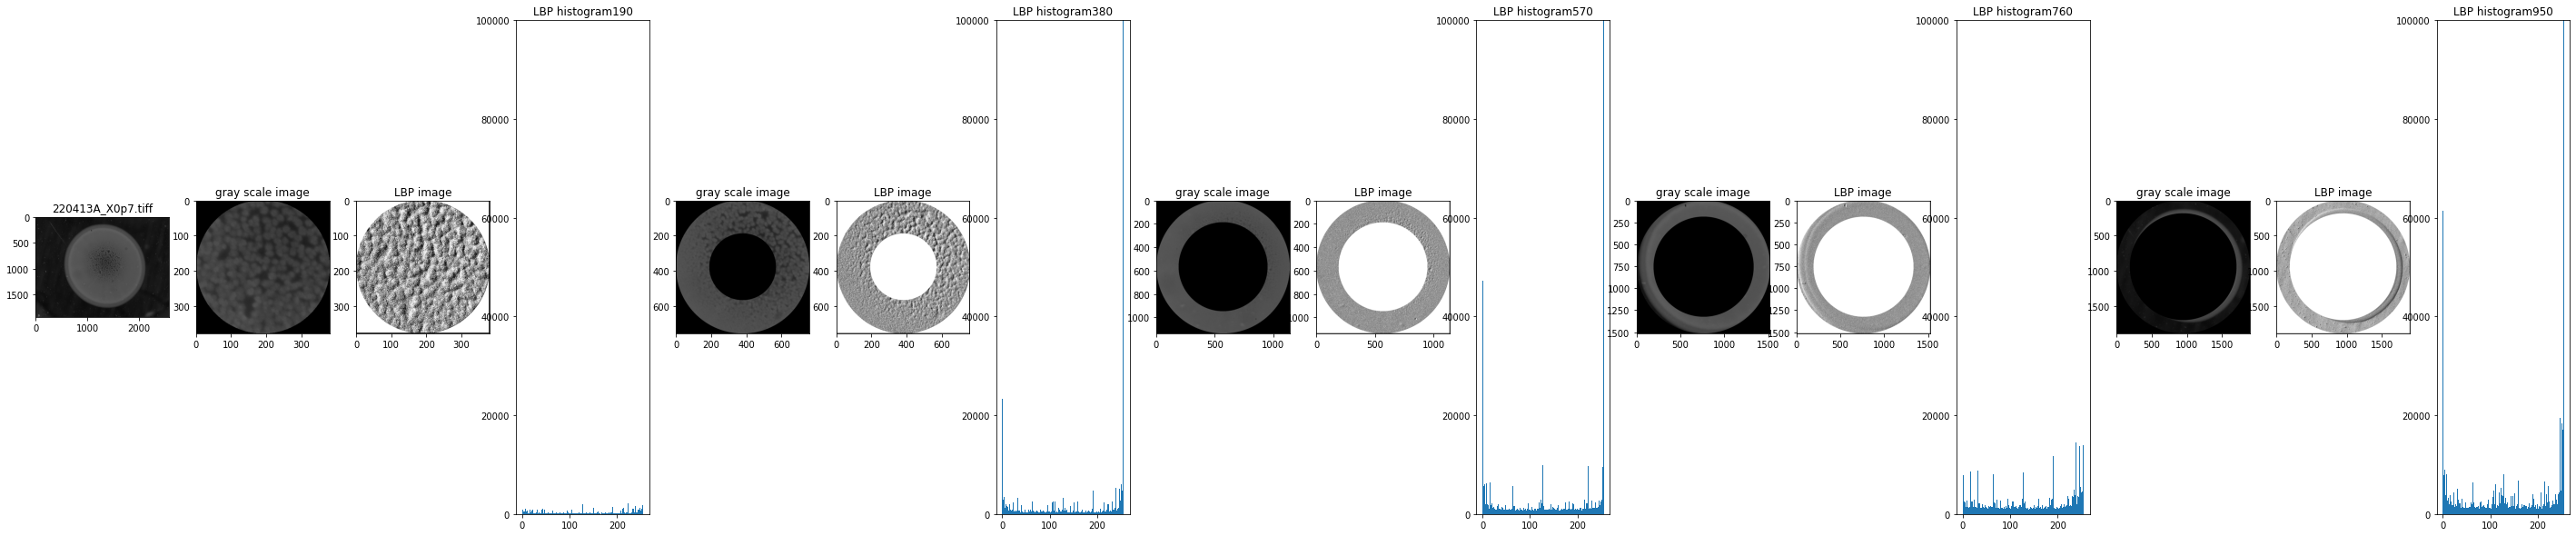

/Users/bruceliu/projects/milk_cls/data/raw/220413/tiff/transmission/dark_blue/220413B_X0p7.tiff
/Users/bruceliu/projects/milk_cls/data/raw/220413/tiff/transmission/dark_blue/220413C_X0p7.tiff
/Users/bruceliu/projects/milk_cls/data/raw/220413/tiff/transmission/dark_blue/220413D_X0p7.tiff
/Users/bruceliu/projects/milk_cls/data/raw/220413/tiff/transmission/dark_blue/220413E_X0p7.tiff
/Users/bruceliu/projects/milk_cls/data/raw/220413/tiff/transmission/dark_blue/220413F_X0p7.tiff
/Users/bruceliu/projects/milk_cls/data/raw/220413/tiff/transmission/dark_blue/220413G_X0p7.tiff
/Users/bruceliu/projects/milk_cls/data/raw/220413/tiff/transmission/dark_blue/220413H_X0p7.tiff
/Users/bruceliu/projects/milk_cls/data/raw/220413/tiff/transmission/dark_blue/220413I_X0p7.tiff
/Users/bruceliu/projects/milk_cls/data/raw/220413/tiff/transmission/dark_blue/220413J_X0p7.tiff
/Users/bruceliu/projects/milk_cls/data/raw/220413/tiff/transmission/dark_blue/220413K_X0p7.tiff
/Users/bruceliu/projects/milk_cls/data/r

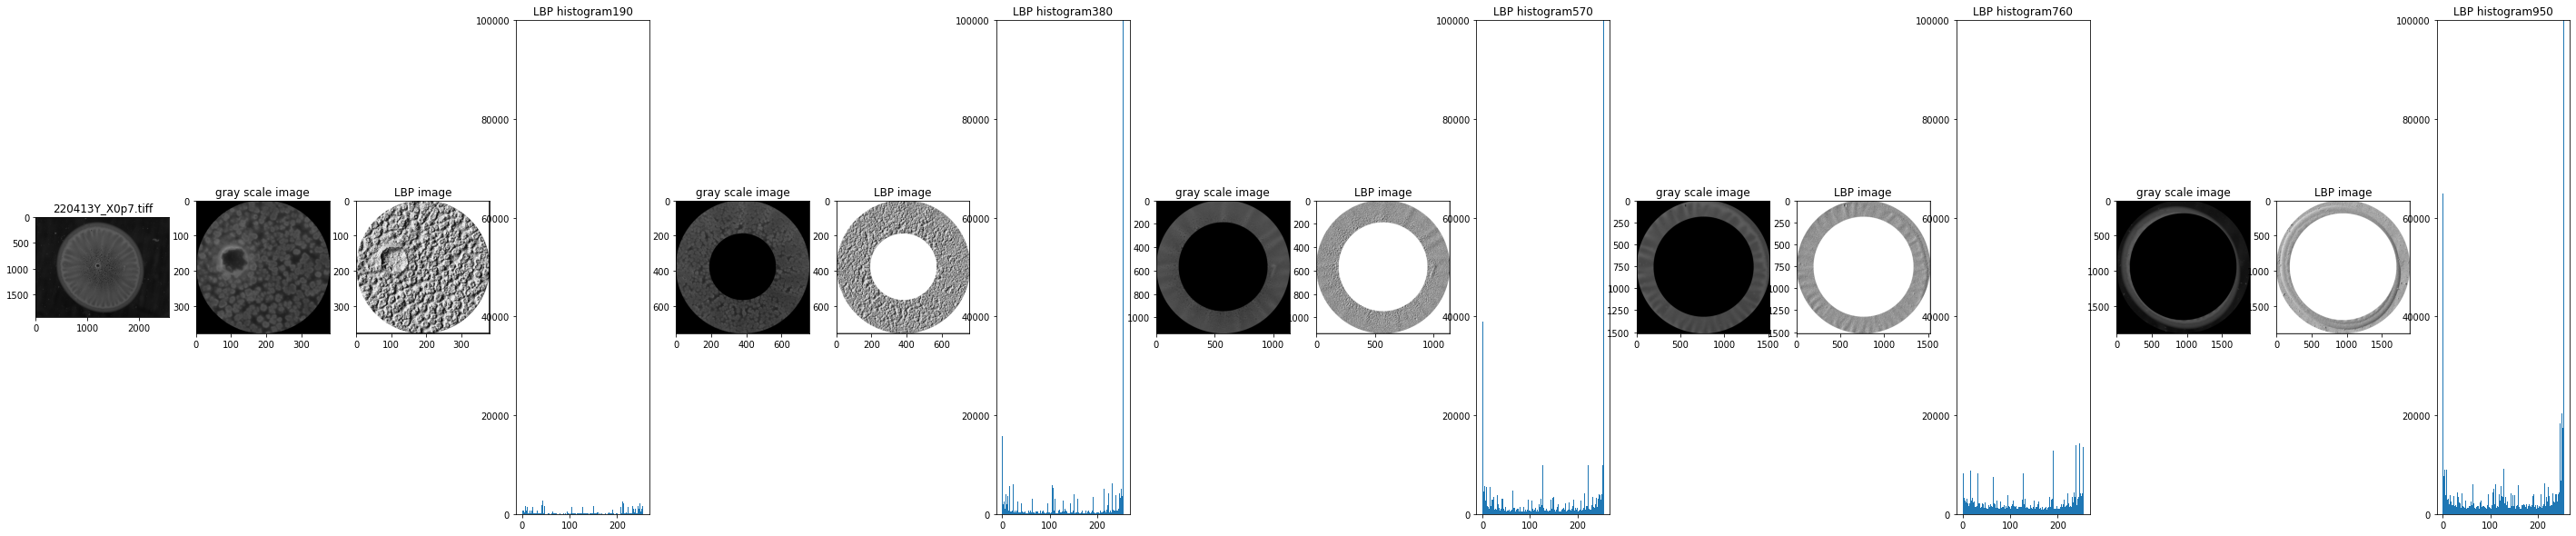

/Users/bruceliu/projects/milk_cls/data/raw/220413/tiff/transmission/dbm_gm/220413ZA_X0p7.tiff
/Users/bruceliu/projects/milk_cls/data/raw/220413/tiff/transmission/dbm_gm/220413ZB_X0p7.tiff
/Users/bruceliu/projects/milk_cls/data/raw/220413/tiff/transmission/dbm_gm/220413ZC_X0p7.tiff
/Users/bruceliu/projects/milk_cls/data/raw/220413/tiff/transmission/dbm_gm/220413ZD_X0p7.tiff
/Users/bruceliu/projects/milk_cls/data/raw/220413/tiff/transmission/dbm_gm/220413ZE_X0p7.tiff
/Users/bruceliu/projects/milk_cls/data/raw/220413/tiff/transmission/dbm_gm/220413ZF_X0p7.tiff
/Users/bruceliu/projects/milk_cls/data/raw/220413/tiff/transmission/dbm_gm/220413ZG_X0p7.tiff
/Users/bruceliu/projects/milk_cls/data/raw/220413/tiff/transmission/dbm_gm/220413ZH_X0p7.tiff
/Users/bruceliu/projects/milk_cls/data/raw/220413/tiff/transmission/dbm_gm/220413ZI_X0p7.tiff
/Users/bruceliu/projects/milk_cls/data/raw/220413/tiff/transmission/dbm_gm/220413ZJ_X0p7.tiff
/Users/bruceliu/projects/milk_cls/data/raw/220413/tiff/trans

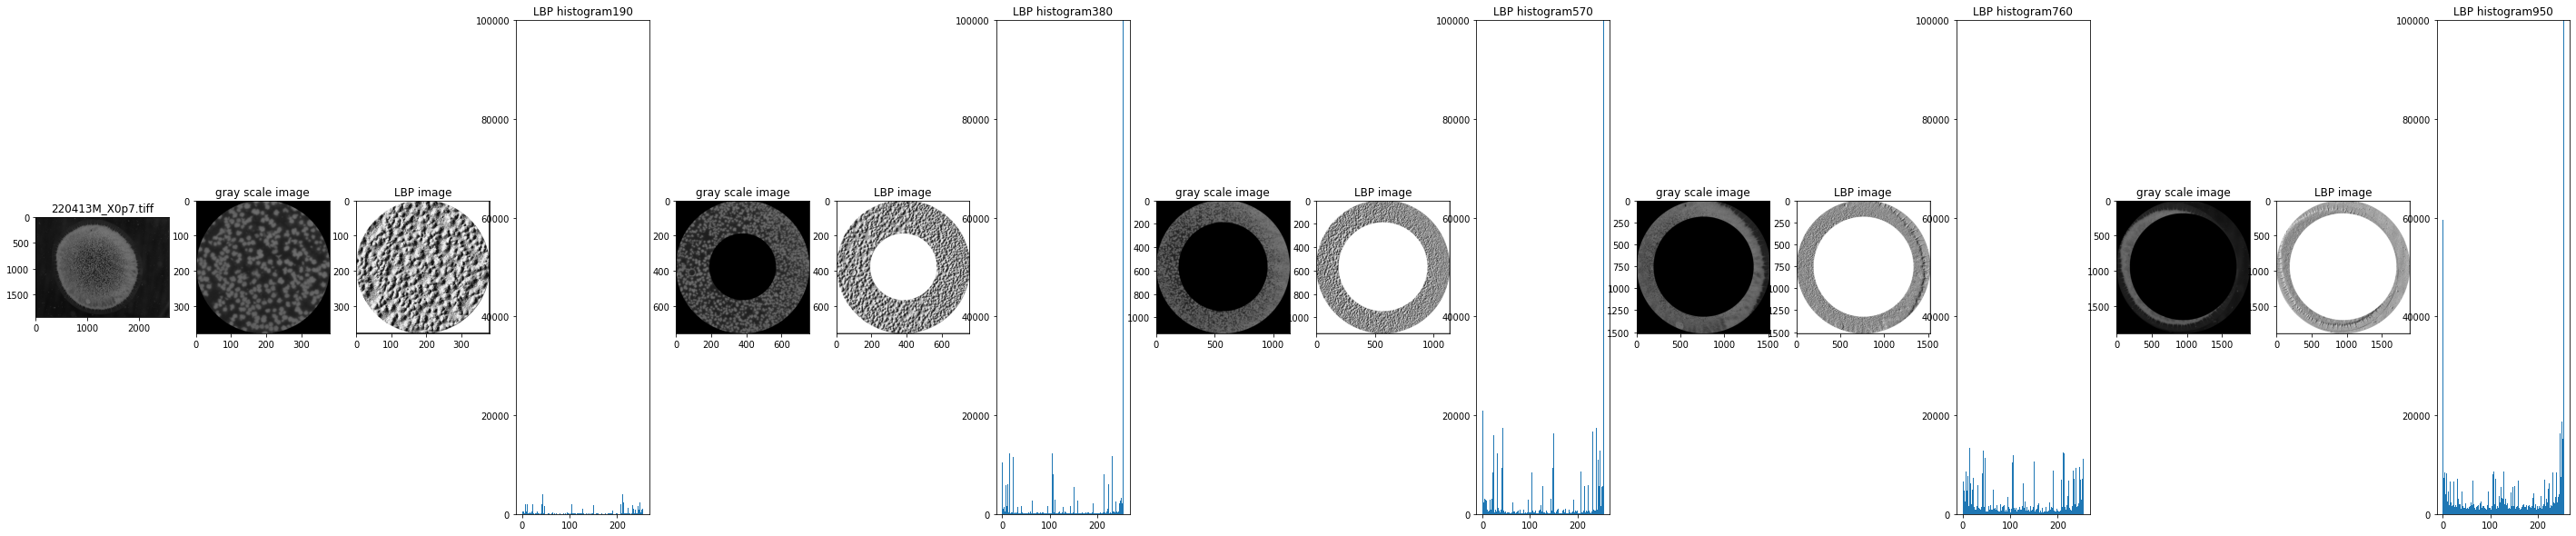

/Users/bruceliu/projects/milk_cls/data/raw/220413/tiff/transmission/green_trim/220413N_X0p7.tiff
/Users/bruceliu/projects/milk_cls/data/raw/220413/tiff/transmission/green_trim/220413O_X0p7.tiff
/Users/bruceliu/projects/milk_cls/data/raw/220413/tiff/transmission/green_trim/220413P_X0p7.tiff
/Users/bruceliu/projects/milk_cls/data/raw/220413/tiff/transmission/green_trim/220413Q_X0p7.tiff
/Users/bruceliu/projects/milk_cls/data/raw/220413/tiff/transmission/green_trim/220413R_X0p7.tiff
/Users/bruceliu/projects/milk_cls/data/raw/220413/tiff/transmission/green_trim/220413S_X0p7.tiff
/Users/bruceliu/projects/milk_cls/data/raw/220413/tiff/transmission/green_trim/220413T_X0p7.tiff
/Users/bruceliu/projects/milk_cls/data/raw/220413/tiff/transmission/green_trim/220413U_X0p7.tiff
/Users/bruceliu/projects/milk_cls/data/raw/220413/tiff/transmission/green_trim/220413V_X0p7.tiff
/Users/bruceliu/projects/milk_cls/data/raw/220413/tiff/transmission/green_trim/220413W_X0p7.tiff
/Users/bruceliu/projects/milk_

In [14]:
trans_image_path = '../data/raw/220413/tiff/transmission'
trans_dark_blue = Path(str(trans_image_path) + '/dark_blue').resolve()
trans_db_data, trans_db_labels = create_lbp_by_rings(trans_dark_blue)

trans_dbm_path = Path(str(trans_image_path) + '/dbm_gm').resolve()
trans_dbm_data, trans_dbm_labels = create_lbp_by_rings(trans_dbm_path)
trans_green_trim = Path(str(trans_image_path) + '/green_trim').resolve()
trans_gt_data, trans_gt_labels =create_lbp_by_rings(trans_green_trim)


In [15]:
trans_all_vector_data = []
for i in range(5):
    trans_all_vector_data.append(trans_db_data[i] + trans_dbm_data[i] + trans_gt_data[i])
trans_all_labels = trans_db_labels + trans_dbm_labels + trans_gt_labels
trans_result_acs = []
for i in range(5):
#     print('The ', i, ' th circle:')
    data, labels = trans_all_vector_data[i],  trans_all_labels
    trans_result_acs.append(measure_performance(data, labels, True if i==0 else False))
trans_merged_vectors = []
for j in range(len(trans_all_vector_data[0])):
    trans_merged_vector = np.concatenate(([NormalizeData(trans_all_vector_data[i][j].flatten()) for i in range(4)]), -1)
    trans_merged_vectors.append(trans_merged_vector)
#     data, labels = all_vector_data[i],  all_labels
trans_result_acs.append(measure_performance(trans_merged_vectors, trans_all_labels))


T ['green_trim', 'dbm_gm', 'green_trim', 'green_trim', 'dbm_gm', 'green_trim', 'dbm_gm', 'dbm_gm']
P ['green_trim', 'dbm_gm', 'green_trim', 'green_trim', 'dbm_gm', 'green_trim', 'dark_blue', 'dark_blue']
KNN:  0.75
P ['green_trim', 'dark_blue', 'dbm_gm', 'dark_blue', 'dbm_gm', 'dbm_gm', 'dark_blue', 'dark_blue']
GradientBoosting:  0.25
P ['dbm_gm', 'green_trim', 'dark_blue', 'dark_blue', 'green_trim', 'dark_blue', 'dark_blue', 'dark_blue']
DecisionTree:  0.0
P ['green_trim', 'green_trim', 'green_trim', 'green_trim', 'green_trim', 'green_trim', 'green_trim', 'green_trim']
KNN:  0.5
P ['dbm_gm', 'green_trim', 'green_trim', 'dbm_gm', 'dbm_gm', 'dbm_gm', 'dark_blue', 'dark_blue']
GradientBoosting:  0.25
P ['dbm_gm', 'green_trim', 'green_trim', 'dbm_gm', 'dbm_gm', 'dbm_gm', 'green_trim', 'green_trim']
DecisionTree:  0.25
P ['green_trim', 'green_trim', 'green_trim', 'green_trim', 'green_trim', 'green_trim', 'green_trim', 'green_trim']
KNN:  0.5
P ['green_trim', 'dark_blue', 'green_trim', 'da

In [16]:
two_merged_vectors = []
for j in range(len(trans_all_vector_data[0])):
    two_merged_vector = np.concatenate((trans_all_vector_data[0][j].flatten(),ref_all_vector_data[0][j].flatten()), -1)
    two_merged_vectors.append(two_merged_vector)

trans_result_acs.append(measure_performance(two_merged_vectors, trans_all_labels))



P ['green_trim', 'green_trim', 'green_trim', 'green_trim', 'green_trim', 'green_trim', 'green_trim', 'green_trim']
KNN:  0.5
P ['green_trim', 'dark_blue', 'dark_blue', 'dark_blue', 'dbm_gm', 'dbm_gm', 'green_trim', 'dark_blue']
GradientBoosting:  0.25
P ['green_trim', 'green_trim', 'dark_blue', 'dark_blue', 'dbm_gm', 'dark_blue', 'dark_blue', 'dark_blue']
DecisionTree:  0.25


In [17]:
import pandas as pd
trans_df = pd.DataFrame(trans_result_acs, columns=['KNN', 'GradientBoost', 'Decision Tree'], 
                  index=['Ring 1', 'Ring 2', 'Ring 3', 'Ring 4', 'Ring 5', 'Merged 1,2,3,4', 'Merge Ring 1'])
print('Transmission: The accuracy of different classifiers using the data from distinguished rings and merged rings')
trans_df

Transmission: The accuracy of different classifiers using the data from distinguished rings and merged rings


,KNN,GradientBoost,Decision Tree
Ring 1,0.75,0.25,0.00
Ring 2,0.50,0.25,0.25
Ring 3,0.50,0.25,0.25
Ring 4,0.50,0.50,0.62
Ring 5,0.25,0.38,0.25
"Merged 1,2,3,4",0.50,0.25,0.25
Merge Ring 1,0.50,0.25,0.25


In [18]:
trans_result_acs.append(measure_performance(two_merged_vectors, all_labels))

P ['green_trim', 'green_trim', 'green_trim', 'green_trim', 'green_trim', 'green_trim', 'green_trim', 'green_trim']
KNN:  0.5
P ['green_trim', 'dark_blue', 'dark_blue', 'dark_blue', 'dbm_gm', 'dbm_gm', 'green_trim', 'dark_blue']
GradientBoosting:  0.25
P ['green_trim', 'green_trim', 'dark_blue', 'dark_blue', 'dbm_gm', 'dark_blue', 'dark_blue', 'dark_blue']
DecisionTree:  0.25


In [19]:
import pandas as pd
trans_df = pd.DataFrame(trans_result_acs, columns=['KNN', 'GradientBoost', 'Decision Tree'], 
                  index=['Ring 1', 'Ring 2', 'Ring 3', 'Ring 4', 'Ring 5', 'Merged 1,2,3,4', 'Merge Ring 1 to trans', 'Merge Ring 1 to ref'])
print('Transmission: The accuracy of different classifiers using the data from distinguished rings and merged rings')
trans_df

Transmission: The accuracy of different classifiers using the data from distinguished rings and merged rings


,KNN,GradientBoost,Decision Tree
Ring 1,0.75,0.25,0.00
Ring 2,0.50,0.25,0.25
Ring 3,0.50,0.25,0.25
Ring 4,0.50,0.50,0.62
Ring 5,0.25,0.38,0.25
"Merged 1,2,3,4",0.50,0.25,0.25
Merge Ring 1 to trans,0.50,0.25,0.25
Merge Ring 1 to ref,0.50,0.25,0.25
